In [1]:
import numpy as np
import pandas as pd
import catboost as cbt
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import gc
import math
import time
from tqdm import tqdm
import datetime
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import os

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#解决matplotlib绘图中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.sans-serif'] = ['KaiTi']   # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

In [2]:
train = pd.read_csv(r'E:\Study\机器学习\wb\first_round_training_data.csv')
test = pd.read_csv(r'E:\Study\机器学习\wb\first_round_testing_data.csv')

start_index = 1
end_index = 11

submit = pd.read_csv(r'E:\Study\机器学习\wb\submit_example.csv')

In [3]:
print(train.describe())

          Parameter1    Parameter2     Parameter3     Parameter4  \
count    6000.000000  6.000000e+03    6000.000000    6000.000000   
mean      485.198954  1.952379e+03     406.348529     189.205842   
std     11401.971393  5.419588e+04   12018.898941    2621.779049   
min         0.000003  1.683797e-07       0.000005       0.000002   
25%         0.088221  4.765771e-02       0.102304       0.118314   
50%         1.050304  9.405962e-01       1.044908       1.068467   
75%        10.938565  1.569199e+01      10.665397       9.902064   
max    713682.207601  3.034568e+06  864530.632179  139767.494732   

         Parameter5    Parameter6    Parameter7    Parameter8    Parameter9  \
count  6.000000e+03  6.000000e+03   6000.000000   6000.000000  6.000000e+03   
mean   5.868163e+00  5.598597e+00    272.300821     22.133231  5.823664e+04   
std    8.631865e+00  7.686898e+00   2027.460514    302.172768  3.173068e+06   
min    9.985942e-07  9.810610e-07      0.000624      0.023699  3.962831

In [4]:
print(test.describe())

           Group    Parameter1  Parameter10     Parameter2    Parameter3  \
count  6000.0000  6.000000e+03  6000.000000    6000.000000  6.000000e+03   
mean     59.5000  1.072897e+05    26.514627     369.101132  1.132272e+03   
std      34.6427  2.980241e+06    84.807106    6352.033456  3.220140e+04   
min       0.0000  1.331475e-09     0.001024       0.000001  5.436324e-08   
25%      29.7500  2.233015e-02     0.101478       0.090422  6.985572e-02   
50%      59.5000  8.489791e-01     0.727611       1.000019  8.985648e-01   
75%      89.2500  3.103161e+01    10.060093      12.159195  1.300345e+01   
max     119.0000  1.758842e+08   517.197610  317368.685606  2.183219e+06   

         Parameter4   Parameter5   Parameter6    Parameter7    Parameter8  \
count  6.000000e+03  6000.000000  6000.000000   6000.000000   6000.000000   
mean   2.196607e+07     5.019799     5.404172    210.884571     59.810770   
std    1.429351e+09     6.782677     6.788654   1616.938611   1545.270888   
min    

In [5]:
train.head(10)

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,6.856075,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.000362,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.022201,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.459004,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,11.576647,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail
5,0.004062,14.556483,0.786945,0.010545,0.000525,0.001623,2286.523413,0.035407,0.593081,1.010385,0.001555,8.998940,6.392712,16.107479,1.016071,86.064258,0.576380,123.057489,16.133884,0.598517,Good
6,0.438449,1.232559,2.882699,0.610757,1.600654,0.464037,0.600827,17.850021,0.051850,0.010192,10.690637,0.034557,0.000971,1.021246,1.791292,0.377312,0.035493,0.146690,41.285376,5.985572,Good
7,48159.917401,0.002987,14.863813,0.063287,1.434060,0.314162,0.600827,17.850021,0.051850,0.010192,0.057851,0.255094,0.090395,21.035514,29.608630,0.581454,0.615609,3.321156,0.013034,0.045039,Good
8,1.456601,52.381578,20.625283,366.074831,1.434060,0.258497,0.600827,17.850021,0.051850,0.010192,120.791843,49.151635,43.315938,0.581297,0.753916,0.610076,0.029777,0.007033,3.397996,20.322889,Pass
9,0.000109,4.784654,31.916672,20.672388,1.284806,0.175007,0.600827,17.850021,0.051850,0.010192,0.000306,0.020348,58.681014,8.387914,33.362518,0.108174,1.356619,1.081445,0.056060,0.413597,Good


In [6]:
data = train.append(test).reset_index(drop=True)
dit = {'Excellent': 0, 'Good': 1, 'Pass': 2, 'Fail': 3}
data['label'] = data['Quality_label'].map(dit)
data.head(10)

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label,Group,label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,6.856075,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass,NaN,2.0
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.000362,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail,NaN,3.0
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.022201,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail,NaN,3.0
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.459004,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail,NaN,3.0
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,11.576647,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail,NaN,3.0
5,0.004062,14.556483,0.786945,0.010545,0.000525,0.001623,2286.523413,0.035407,0.593081,1.010385,0.001555,8.998940,6.392712,16.107479,1.016071,86.064258,0.576380,123.057489,16.133884,0.598517,Good,NaN,1.0
6,0.438449,1.232559,2.882699,0.610757,1.600654,0.464037,0.600827,17.850021,0.051850,0.010192,10.690637,0.034557,0.000971,1.021246,1.791292,0.377312,0.035493,0.146690,41.285376,5.985572,Good,NaN,1.0
7,48159.917401,0.002987,14.863813,0.063287,1.434060,0.314162,0.600827,17.850021,0.051850,0.010192,0.057851,0.255094,0.090395,21.035514,29.608630,0.581454,0.615609,3.321156,0.013034,0.045039,Good,NaN,1.0
8,1.456601,52.381578,20.625283,366.074831,1.434060,0.258497,0.600827,17.850021,0.051850,0.010192,120.791843,49.151635,43.315938,0.581297,0.753916,0.610076,0.029777,0.007033,3.397996,20.322889,Pass,NaN,2.0
9,0.000109,4.784654,31.916672,20.672388,1.284806,0.175007,0.600827,17.850021,0.051850,0.010192,0.000306,0.020348,58.681014,8.387914,33.362518,0.108174,1.356619,1.081445,0.056060,0.413597,Good,NaN,1.0


In [7]:
print(train.isnull().sum())

Parameter1       0
Parameter2       0
Parameter3       0
Parameter4       0
Parameter5       0
Parameter6       0
Parameter7       0
Parameter8       0
Parameter9       0
Parameter10      0
Attribute1       0
Attribute2       0
Attribute3       0
Attribute4       0
Attribute5       0
Attribute6       0
Attribute7       0
Attribute8       0
Attribute9       0
Attribute10      0
Quality_label    0
dtype: int64


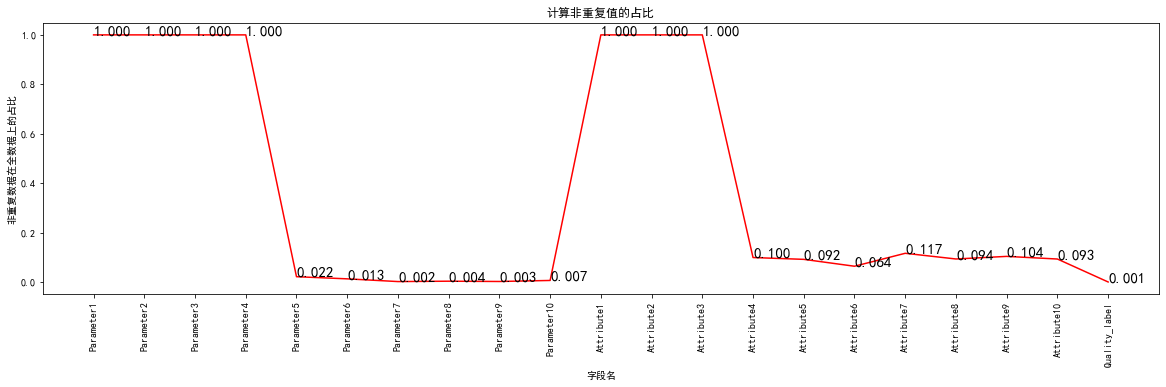

In [8]:
col_name = train.columns
Notdlts_count = []
for i in col_name:
    Notdlts = len(train[i].drop_duplicates())/6000
    Notdlts_count.append(Notdlts)

plt.figure(figsize=(20,5))


plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.sans-serif'] = ['KaiTi']   # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

plt.plot(col_name, Notdlts_count, c='r')
plt.title('计算非重复值的占比')                 
plt.xlabel('字段名')                        
plt.ylabel('非重复数据在全数据上的占比')  
plt.xticks(rotation=90)                   
for x,y in zip(col_name,Notdlts_count):
    plt.text(x,y,'%.3f' % y,fontdict={'fontsize':15}) 

plt.show()

In [9]:
feature_name = ['Parameter{0}'.format(i) for i in range(start_index, end_index)]
tr_index = ~data['label'].isnull()
X_train_org = data[tr_index][feature_name].reset_index(drop=True)
y = data[tr_index]['label'].reset_index(drop=True).astype(int)
X_test_org = data[~tr_index][feature_name].reset_index(drop=True)

X_train_dis = pd.DataFrame()
X_test_dis = pd.DataFrame()

classdf = pd.DataFrame(y)
for classindex in range(4):
    class_row_index_list = classdf[(classdf['label'] == classindex)].index.tolist()

    df_train_temp = X_train_org.iloc[class_row_index_list]

    print('class{0} is len is {1}'.format(classindex, len(df_train_temp)))

    for Parameter in range(start_index, end_index):
        Parameter_std = df_train_temp['Parameter{0}'.format(Parameter)].std()
        Parameter_mean = df_train_temp['Parameter{0}'.format(Parameter)].mean()
        X_train_dis['Parameter{0}class{1}dis_mean'.format(Parameter, classindex)] = X_train_org['Parameter{0}'.format(
            Parameter)] - Parameter_mean
        X_test_dis['Parameter{0}class{1}dis_mean'.format(Parameter, classindex)] = X_test_org['Parameter{0}'.format(
            Parameter)] - Parameter_mean

class0 is len is 1107
class1 is len is 1584
class2 is len is 2417
class3 is len is 892


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile


def make_feature(df_temp, degree_level):
    poly = PolynomialFeatures(degree=degree_level, include_bias=False, interaction_only=False)
    X_ploly = poly.fit_transform(df_temp)
    df_temp = pd.DataFrame(X_ploly, columns=poly.get_feature_names())
    return df_temp


In [11]:
X_train_org_ploly3 = pd.DataFrame()
X_test_org_ploly3 = pd.DataFrame()
for Parameter in range(start_index, end_index):
    Parameter_std = X_train_org['Parameter{0}'.format(Parameter)].std()
    Parameter_mean = X_train_org['Parameter{0}'.format(Parameter)].mean()
    X_train_org_ploly3['Parameter{0}'.format(Parameter)] = (X_train_org['Parameter{0}'.format(
        Parameter)] - Parameter_mean) / Parameter_std
    X_test_org_ploly3['Parameter{0}'.format(Parameter)] = (X_test_org['Parameter{0}'.format(
        Parameter)] - Parameter_mean) / Parameter_std


In [12]:
X_train_ploly_3 = make_feature(X_train_org_ploly3, 3)
select = SelectPercentile(percentile=100) 
select.fit(X_train_ploly_3, y)
mask = select.get_support()

feature_used = []
for index in range(len(mask)):
    if mask[index]:
        feature_used.append(list(X_train_ploly_3.columns.values)[index])

X_train_ploly_3 = X_train_ploly_3[feature_used]
X_test_ploly_3 = make_feature(X_test_org_ploly3, 3)
X_test_ploly_3 = X_test_ploly_3[feature_used]

clusterdic = {1: 5, 2: 4, 3: 4, 4: 6, 5: 6, 6: 6, 7: 3, 8: 4, 9: 2, 10: 5}

from sklearn.cluster import KMeans


def getclusterfeature(df_train, df_predict1, df_predict2):
    df_temp1 = pd.DataFrame()
    df_temp2 = pd.DataFrame()
    for i in range(start_index, end_index):
        colindex = i
        df_features = df_train[['Parameter{0}'.format(colindex)]]

        estimator = KMeans(n_clusters=clusterdic[colindex])  # 构造聚类器
        estimator.fit(df_features)
        predictclass1 = estimator.predict(df_predict1[['Parameter{0}'.format(colindex)]])
        df_temp1['Parametercluter{0}'.format(colindex)] = predictclass1.tolist()
        predictclass2 = estimator.predict(df_predict2[['Parameter{0}'.format(colindex)]])
        df_temp2['Parametercluter{0}'.format(colindex)] = predictclass2.tolist()

    return df_temp1, df_temp2

X_train_cluster, X_test_cluster = getclusterfeature(X_train_org, X_train_org, X_test_org)

from sklearn.feature_selection import SelectPercentile

percent = 13
X_train = pd.concat([X_train_dis, X_train_ploly_3, X_train_cluster], axis=1)
X_test = pd.concat([X_test_dis, X_test_ploly_3, X_test_cluster], axis=1)
list_file = open('percent.txt', 'a')


select = SelectPercentile(percentile=percent)  
select.fit(X_train, y)

mask = select.get_support()

feature_used = []
for index in range(len(mask)):
    if mask[index]:
        feature_used.append(list(X_train.columns.values)[index])

In [13]:
print('最终特征选择')
print(feature_used)
list_file.write(','.join(feature_used) + '\n')
X_train = X_train[feature_used]
X_test = X_test[feature_used]
print('最终特征维度')
print(X_train.shape, X_test.shape)

最终特征选择
['Parameter5class0dis_mean', 'Parameter6class0dis_mean', 'Parameter7class0dis_mean', 'Parameter10class0dis_mean', 'Parameter5class1dis_mean', 'Parameter6class1dis_mean', 'Parameter7class1dis_mean', 'Parameter10class1dis_mean', 'Parameter5class2dis_mean', 'Parameter6class2dis_mean', 'Parameter7class2dis_mean', 'Parameter10class2dis_mean', 'Parameter5class3dis_mean', 'Parameter6class3dis_mean', 'Parameter7class3dis_mean', 'Parameter10class3dis_mean', 'x4', 'x5', 'x6', 'x9', 'x4^2', 'x4 x5', 'x4 x6', 'x5^2', 'x5 x6', 'x6^2', 'x9^2', 'x2 x6^2', 'x4^3', 'x4^2 x5', 'x4^2 x6', 'x4 x5^2', 'x4 x5 x6', 'x4 x6^2', 'x5^3', 'x5^2 x6', 'x5 x6^2', 'x6^3', 'x6^2 x7', 'x7 x9^2', 'x9^3', 'Parametercluter5', 'Parametercluter6', 'Parametercluter7']
最终特征维度
(6000, 44) (6000, 44)


In [14]:
pred = np.zeros((X_test.shape[0],4)) 

In [15]:
def gdbt_model():
    model =GradientBoostingClassifier()
    model.fit(X_train,y)
    pred = model.predict_proba(X_test) 
    MAE = 1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480)
    gdbt_score = 1/(1+10*MAE)
    print('log_loss',log_loss(pd.get_dummies(y).values, pred))
    print('gbdt_ac',accuracy_score(y,np.argmax(pred,axis = 1)))
    print('MAE',1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480))
    print('gdbt_score',1/(1+10*MAE))
    print('--------------------------------')

    return model
gdbt_model()

log_loss 1.5451948419850454
gbdt_ac 0.3045
MAE 0.05329754283727099
gdbt_score 0.6523261765920957
--------------------------------


GradientBoostingClassifier()

In [16]:
def cbt_model():
    model = cbt.CatBoostClassifier(iterations=1200, learning_rate=0.05, verbose=300,
                                       early_stopping_rounds=400, 
                                        loss_function='MultiClass')
    model.fit(X_train,y)
    
    pred = model.predict_proba(X_test) 
    MAE = 1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480)
    gdbt_then_score = 1/(1+10*MAE)
    print('log_loss',log_loss(pd.get_dummies(y).values, pred))
    print('cbt_ac',accuracy_score(y,np.argmax(pred,axis = 1)))
    print('MAE',1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480))
    print('cbt_score',1/(1+10*MAE))
    print('--------------------------------')

    return model
cbt_model()

0:	learn: 1.3650361	total: 197ms	remaining: 3m 56s
300:	learn: 1.0011697	total: 3.74s	remaining: 11.2s
600:	learn: 0.9235854	total: 7.32s	remaining: 7.3s
900:	learn: 0.8634229	total: 11.2s	remaining: 3.7s
1199:	learn: 0.8161327	total: 14.9s	remaining: 0us
log_loss 1.657185490182091
cbt_ac 0.3016666666666667
MAE 0.05326152536899948
cbt_score 0.6524794775416427
--------------------------------


In [17]:
def lightGBM_model():
    model = LGBMClassifier(verbose=2)
    model.fit(X_train,y,eval_set=[(X_test,y)])##算法训练（加上交叉验证集）

    pred = model.predict_proba(X_test) 
    MAE = 1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480)
    lightGBM_score = 1/(1+10*MAE)
    print('log_loss',log_loss(pd.get_dummies(y).values, pred))
    print('lightGBM_ac',accuracy_score(y,np.argmax(pred,axis = 1)))
    print('MAE',1/(1 + np.sum(np.absolute(np.eye(4)[y] - pred))/480))
    print('lightGBM_score',1/(1+10*MAE))
    print('--------------------------------')
    return model
lightGBM_model()    

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.010271
[LightGBM] [Debug] init for col-wise cost 0.000057 seconds, init for row-wise cost 0.004381 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4580
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.690106
[LightGBM] [Info] Start training from score -1.331806
[LightGBM] [Info] Start training from score -0.909232
[LightGBM] [Info] Start training from score -1.906049
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained

[30]	valid_0's multi_logloss: 1.5746
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[31]	valid_0's multi_logloss: 1.5782
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[32]	valid_0's multi_logloss: 1.58283
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[33]	valid_0's multi_logloss: 1.58581
[LightGBM] [Debug] Trained a tree with leaves = 31 and dep

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[74]	valid_0's multi_logloss: 1.68458
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[75]	valid_0's multi_logloss: 1.6864
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[76]	valid_0's multi_logloss: 1.68844
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[77]	valid_0's multi_logloss:

LGBMClassifier(verbose=2)

In [19]:
gdbt_model = GradientBoostingClassifier()
gdbt_model.fit(X_train,y)
gdbt_pred = gdbt_model.predict_proba(X_test)

cbt_model = cbt.CatBoostClassifier()
cbt_model.fit(X_train,y)
cbt_pred = cbt_model.predict_proba(X_test)

lightGBM_model = LGBMClassifier(verbose=2)
lightGBM_model.fit(X_train,y)
lightGBM_pred = lightGBM_model.predict_proba(X_test)

Learning rate set to 0.086698
0:	learn: 1.3501150	total: 43.4ms	remaining: 43.4s
1:	learn: 1.3194145	total: 76.6ms	remaining: 38.2s
2:	learn: 1.2921707	total: 110ms	remaining: 36.5s
3:	learn: 1.2733813	total: 142ms	remaining: 35.3s
4:	learn: 1.2574871	total: 171ms	remaining: 34.1s
5:	learn: 1.2423910	total: 208ms	remaining: 34.4s
6:	learn: 1.2293868	total: 238ms	remaining: 33.8s
7:	learn: 1.2181283	total: 276ms	remaining: 34.3s
8:	learn: 1.2056083	total: 298ms	remaining: 32.8s
9:	learn: 1.1953261	total: 314ms	remaining: 31s
10:	learn: 1.1866064	total: 327ms	remaining: 29.4s
11:	learn: 1.1790021	total: 339ms	remaining: 27.9s
12:	learn: 1.1721870	total: 350ms	remaining: 26.6s
13:	learn: 1.1661616	total: 360ms	remaining: 25.4s
14:	learn: 1.1593437	total: 372ms	remaining: 24.4s
15:	learn: 1.1538678	total: 384ms	remaining: 23.6s
16:	learn: 1.1515550	total: 392ms	remaining: 22.7s
17:	learn: 1.1456030	total: 405ms	remaining: 22.1s
18:	learn: 1.1401308	total: 417ms	remaining: 21.5s
19:	learn: 

167:	learn: 1.0069355	total: 2.18s	remaining: 10.8s
168:	learn: 1.0063341	total: 2.19s	remaining: 10.8s
169:	learn: 1.0053767	total: 2.21s	remaining: 10.8s
170:	learn: 1.0048867	total: 2.22s	remaining: 10.8s
171:	learn: 1.0045577	total: 2.23s	remaining: 10.8s
172:	learn: 1.0041208	total: 2.24s	remaining: 10.7s
173:	learn: 1.0033412	total: 2.26s	remaining: 10.7s
174:	learn: 1.0028074	total: 2.27s	remaining: 10.7s
175:	learn: 1.0021444	total: 2.28s	remaining: 10.7s
176:	learn: 1.0015294	total: 2.29s	remaining: 10.7s
177:	learn: 1.0009350	total: 2.3s	remaining: 10.6s
178:	learn: 1.0004260	total: 2.31s	remaining: 10.6s
179:	learn: 0.9998323	total: 2.33s	remaining: 10.6s
180:	learn: 0.9991080	total: 2.34s	remaining: 10.6s
181:	learn: 0.9987299	total: 2.35s	remaining: 10.6s
182:	learn: 0.9980079	total: 2.36s	remaining: 10.5s
183:	learn: 0.9973932	total: 2.37s	remaining: 10.5s
184:	learn: 0.9967220	total: 2.38s	remaining: 10.5s
185:	learn: 0.9963910	total: 2.4s	remaining: 10.5s
186:	learn: 0.

327:	learn: 0.9333799	total: 4.2s	remaining: 8.61s
328:	learn: 0.9331997	total: 4.22s	remaining: 8.6s
329:	learn: 0.9326164	total: 4.23s	remaining: 8.59s
330:	learn: 0.9322901	total: 4.24s	remaining: 8.57s
331:	learn: 0.9320056	total: 4.25s	remaining: 8.56s
332:	learn: 0.9315114	total: 4.27s	remaining: 8.54s
333:	learn: 0.9309525	total: 4.28s	remaining: 8.53s
334:	learn: 0.9305292	total: 4.29s	remaining: 8.52s
335:	learn: 0.9302399	total: 4.3s	remaining: 8.5s
336:	learn: 0.9299094	total: 4.31s	remaining: 8.48s
337:	learn: 0.9294280	total: 4.32s	remaining: 8.47s
338:	learn: 0.9290969	total: 4.34s	remaining: 8.45s
339:	learn: 0.9283432	total: 4.35s	remaining: 8.44s
340:	learn: 0.9279777	total: 4.36s	remaining: 8.43s
341:	learn: 0.9275027	total: 4.38s	remaining: 8.42s
342:	learn: 0.9269360	total: 4.39s	remaining: 8.4s
343:	learn: 0.9263027	total: 4.4s	remaining: 8.39s
344:	learn: 0.9260953	total: 4.41s	remaining: 8.38s
345:	learn: 0.9257061	total: 4.42s	remaining: 8.36s
346:	learn: 0.9252

501:	learn: 0.8703559	total: 6.37s	remaining: 6.32s
502:	learn: 0.8699735	total: 6.39s	remaining: 6.31s
503:	learn: 0.8695448	total: 6.4s	remaining: 6.3s
504:	learn: 0.8692274	total: 6.41s	remaining: 6.29s
505:	learn: 0.8691121	total: 6.42s	remaining: 6.27s
506:	learn: 0.8688079	total: 6.44s	remaining: 6.26s
507:	learn: 0.8684685	total: 6.45s	remaining: 6.25s
508:	learn: 0.8681099	total: 6.46s	remaining: 6.23s
509:	learn: 0.8678746	total: 6.47s	remaining: 6.22s
510:	learn: 0.8675266	total: 6.48s	remaining: 6.2s
511:	learn: 0.8673662	total: 6.49s	remaining: 6.19s
512:	learn: 0.8670827	total: 6.5s	remaining: 6.18s
513:	learn: 0.8667823	total: 6.52s	remaining: 6.16s
514:	learn: 0.8666047	total: 6.53s	remaining: 6.15s
515:	learn: 0.8663835	total: 6.54s	remaining: 6.14s
516:	learn: 0.8662026	total: 6.55s	remaining: 6.12s
517:	learn: 0.8657916	total: 6.56s	remaining: 6.11s
518:	learn: 0.8656139	total: 6.58s	remaining: 6.09s
519:	learn: 0.8653966	total: 6.59s	remaining: 6.08s
520:	learn: 0.86

661:	learn: 0.8253055	total: 8.57s	remaining: 4.38s
662:	learn: 0.8251852	total: 8.59s	remaining: 4.36s
663:	learn: 0.8249857	total: 8.6s	remaining: 4.35s
664:	learn: 0.8247617	total: 8.61s	remaining: 4.34s
665:	learn: 0.8245156	total: 8.62s	remaining: 4.32s
666:	learn: 0.8241738	total: 8.63s	remaining: 4.31s
667:	learn: 0.8238926	total: 8.64s	remaining: 4.29s
668:	learn: 0.8236571	total: 8.65s	remaining: 4.28s
669:	learn: 0.8235614	total: 8.66s	remaining: 4.27s
670:	learn: 0.8233280	total: 8.68s	remaining: 4.25s
671:	learn: 0.8231159	total: 8.69s	remaining: 4.24s
672:	learn: 0.8227194	total: 8.7s	remaining: 4.23s
673:	learn: 0.8224682	total: 8.71s	remaining: 4.21s
674:	learn: 0.8222339	total: 8.72s	remaining: 4.2s
675:	learn: 0.8220716	total: 8.74s	remaining: 4.19s
676:	learn: 0.8219189	total: 8.75s	remaining: 4.17s
677:	learn: 0.8217876	total: 8.76s	remaining: 4.16s
678:	learn: 0.8215262	total: 8.78s	remaining: 4.15s
679:	learn: 0.8213118	total: 8.8s	remaining: 4.14s
680:	learn: 0.82

821:	learn: 0.7875447	total: 10.8s	remaining: 2.33s
822:	learn: 0.7871370	total: 10.8s	remaining: 2.32s
823:	learn: 0.7869494	total: 10.8s	remaining: 2.31s
824:	learn: 0.7866037	total: 10.8s	remaining: 2.29s
825:	learn: 0.7863763	total: 10.8s	remaining: 2.28s
826:	learn: 0.7860994	total: 10.8s	remaining: 2.27s
827:	learn: 0.7857603	total: 10.9s	remaining: 2.25s
828:	learn: 0.7856462	total: 10.9s	remaining: 2.24s
829:	learn: 0.7855412	total: 10.9s	remaining: 2.23s
830:	learn: 0.7853034	total: 10.9s	remaining: 2.21s
831:	learn: 0.7849393	total: 10.9s	remaining: 2.2s
832:	learn: 0.7845926	total: 10.9s	remaining: 2.19s
833:	learn: 0.7843476	total: 10.9s	remaining: 2.18s
834:	learn: 0.7840291	total: 11s	remaining: 2.17s
835:	learn: 0.7838450	total: 11s	remaining: 2.16s
836:	learn: 0.7835720	total: 11s	remaining: 2.15s
837:	learn: 0.7834009	total: 11.1s	remaining: 2.14s
838:	learn: 0.7832000	total: 11.1s	remaining: 2.13s
839:	learn: 0.7829196	total: 11.1s	remaining: 2.12s
840:	learn: 0.78277

992:	learn: 0.7499589	total: 13.2s	remaining: 92.9ms
993:	learn: 0.7498122	total: 13.2s	remaining: 79.6ms
994:	learn: 0.7496949	total: 13.2s	remaining: 66.3ms
995:	learn: 0.7493845	total: 13.2s	remaining: 53.1ms
996:	learn: 0.7492224	total: 13.2s	remaining: 39.8ms
997:	learn: 0.7490389	total: 13.2s	remaining: 26.5ms
998:	learn: 0.7489204	total: 13.2s	remaining: 13.3ms
999:	learn: 0.7486763	total: 13.3s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.010271
[LightGBM] [Debug] init for col-wise cost 0.000028 seconds, init for row-wise cost 0.003260 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4580
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 44
[LightGBM] [Info] Start trainin

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] 

In [22]:
sub = test[['Group']]
prob_cols = [i for i in submit.columns if i not in ['Group']]
for i, f in enumerate(prob_cols):
    sub[f] = cbt_pred[:, i]
for i in prob_cols:
    sub[i] = sub.groupby('Group')[i].transform('mean')
sub = sub.drop_duplicates()

#sub.to_csv(r'E:\Study\机器学习\wb\submit_lightGBM.csv', index=False)
#sub.to_csv(r'E:\Study\机器学习\wb\submit_gdbt.csv', index=False)
sub.to_csv(r'E:\Study\机器学习\wb\submit_cbt.csv', index=False)